<a href="https://www.kaggle.com/code/averma111/pss3e17-binary-classification-pytorch?scriptVersionId=134662704" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

<div style="color:white;
           display:fill;
           border-radius:5px;
           background-color:#5642C5;
           font-size:110%;
           font-family:Verdana;
           letter-spacing:0.2px">

<p style="padding: 30px;
              color:white;">
BINARY CLASSIFICATION OF MACHINE FAILURES
</p>
</div>

In [191]:
%%capture
!pip install torchmetrics

In [192]:
import numpy as np 
import pandas as pd 
import os
import datetime
import seaborn as sns
from tqdm.notebook import tqdm
    
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder,StandardScaler
from imblearn.over_sampling import SMOTE,SMOTENC
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, roc_auc_score

import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader,random_split,Dataset
from torch.utils.tensorboard import SummaryWriter
from torchmetrics import ROC



import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('fivethirtyeight')
import plotly.express as px

import warnings
warnings.filterwarnings('ignore')
import itertools

<div style="color:white;
           display:fill;
           border-radius:5px;
           background-color:#5642C5;
           font-size:110%;
           font-family:Verdana;
           letter-spacing:0.2px">

<p style="padding: 30px;
              color:white;">
DIRECTORY LISTING
</p>
</div>

In [193]:
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


/kaggle/input/playground-series-s3e17/sample_submission.csv
/kaggle/input/playground-series-s3e17/train.csv
/kaggle/input/playground-series-s3e17/test.csv


<div style="color:white;
           display:fill;
           border-radius:5px;
           background-color:#5642C5;
           font-size:110%;
           font-family:Verdana;
           letter-spacing:0.2px">

<p style="padding: 30px;
              color:white;">
GENERIC PYTORCH METHODS
</p>
</div>

In [194]:
class GenericPytorch(object):
    
    def __init__(self,model,loss_fun,optimizer):
        self.model = model
        self.loss_fun = loss_fun 
        self.optimizer = optimizer
        self.device = 'cuda' if torch.cuda.is_available() else 'cpu'
        self.model.to(self.device)
        
        ## Placeholders 
        self.train_loader = None
        self.val_loader = None
        self.writer = None
        
        #Variables 
        self.losses =[]
        self.val_losses = []
        self.total_epoch = 0
        
        self.total_correct = 0
        self.total_samples = 0
        self.best_loss = np.inf
        self.patience = 10
        self.counter = 0
        
        #Helper Function
        self.train_step_fun = self._make_train_step_fun()
        self.val_step_fun = self._make_val_step_fun()
        
        #Metrics
        self.false_positive = []
        self.true_positive = []
        
    def to(self,device):
        try:
            self.device = device
            self.model.to(self.device)
            
        except RuntimeError:
            self.device = ('cuda' if torch.cuda.is_available() else 'cpu')
            print(f'Could not send it {device}, sending it to {self.device} instead')
            self.model.to(self.device)
            
    
    def set_loaders(self,train_loader,val_loader=None):
        self.train_loader = train_loader
        self.val_loader = val_loader
        
        
    def set_tensorboard(self,name,folder='runs'):
        suffix = datetime.datetime.now().strftime('%Y%m%d%H%M%S')
        self.writer = SummaryWriter(f'{folder}/{name}_{suffix}')
        
    def _roc(self,yhat,y):
        roc = ROC(task="binary")
        fpr, tpr, thresholds = roc(yhat,y.long())
        self.false_positive.append(fpr)
        self.true_positive.append(tpr)
        
        
        
        
    def _make_train_step_fun(self):
        
        def perform_train_step_fun(X,y):
            # Set the model to train 
            self.model.train()
            #Step 1 - Forward pass / make  predictions
            yhat = self.model(X)
            #Step 2 - Compute loss 
            loss = self.loss_fun(yhat,y)
            self._roc(yhat,y)
            #Step 3 - Compute the gradients
            loss.backward()
            #Step 4 - Update the variables and set the gradient to 0
            self.optimizer.step()
            self.optimizer.zero_grad()
            
            return loss.item()
        
        return perform_train_step_fun
            
    
    def _make_val_step_fun(self):
        
        def perform_val_step_fun(X,y):
            # Set the model to train 
            self.model.eval()
            #Step 1 - Forward pass / make  predictions
            yhat = self.model(X)
            #Step 2 - Compute loss 
            loss = self.loss_fun(yhat,y)
            
            
            return loss.item()
        
        return perform_val_step_fun
    
    
    def _mini_batch(self,validation=False):
        
        if validation:
            data_loader = self.val_loader
            step_fun = self.val_step_fun
        else:
            data_loader = self.train_loader
            step_fun = self.train_step_fun
        
        if data_loader is None:
            return None
        
        # Loop mini-batch 
        mini_batch_losses =[] 
        for x_batch,y_batch  in data_loader:
            x_batch = x_batch.to(self.device)
            y_batch = y_batch.to(self.device)
            
            mini_batch_loss = step_fun(x_batch,y_batch.unsqueeze(1))
            mini_batch_losses.append(mini_batch_loss)
            loss = np.mean(mini_batch_losses)
            l2_reg = sum(torch.norm(param) for param in self.model.parameters())
            loss = loss + 0.001 * l2_reg
        
        return loss
    
    def set_seed(self,seed=42):
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False
        torch.manual_seed(seed)
        np.random.seed(seed)
        
    
    def train(self,n_epochs,seed=42):
        #Reproducibility
        self.set_seed(seed)
        
        for epoch in tqdm(range(n_epochs)):
            self.total_epoch +=1
            
            #inner loop perform training using mini_batch
            loss = self._mini_batch(validation=False)
            self.losses.append(loss.detach().numpy())
            
            #Validation 
            with torch.no_grad():
                #Perform evaluation using mini-batch
                val_loss = self._mini_batch(validation=True)
                self.val_losses.append(val_loss.detach().numpy())
            """
            #SummaryWriter 
            if self.writer:
                scalars ={
                    'training':loss}
                if val_loss is not None:
                    scalars.update({'validation':val_loss})
            
            """    
  
            if epoch%10==0:
                print(f'Epoch=>[{epoch}]||Training Loss:=>{loss:.5f}||Validation Loss:=>{val_loss:.5f}')
                #Record both losses for each epoch
                #elf.writer.add_scalars(main_tag='loss',tag_scalar_dict=scalars,global_step=epoch)
        
        print('Training Completed!!')
                
                
        if self.writer:
            #Flush the writer 
            self.writer.flush()
        
    
    def save_checkpoint(self,filename):
        #Build the dictionary with all the elements for resuming training
        checkpoint = {
            'epoch':self.total_epoch,
            'model_state_dict':self.model.state_dict(),
            'optimizer_state_dict': self.optimizer.state_dict(),
            'loss': self.losses,
            'val_loss': self.val_losses
        }
        
        torch.save(checkpoint,filename)
        
    
    def load_checkpoint(self, filename):
        # Loads dictionary
        checkpoint = torch.load(filename)

        # Restore state for model and optimizer
        self.model.load_state_dict(checkpoint['model_state_dict'])
        self.optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

        self.total_epochs = checkpoint['epoch']
        self.losses = checkpoint['loss']
        self.val_losses = checkpoint['val_loss']

        self.model.train() # always use TRAIN for resuming training   

    def predict(self,model,test_data_dl):
        probabilities =[]
        with torch.no_grad():
            for X_batch in test_data_dl:
                X_batch = X_batch.to(self.device)
                y_test_pred = model(X_batch)
                y_test_pred = torch.nn.functional.sigmoid(y_test_pred)
                probabilities.append(y_test_pred.detach().numpy())
        return probabilities
    

    def plot_losses(self):
        fig = plt.figure(figsize=(10, 4))
        plt.plot(self.losses, label='Training Loss', c='b')
        plt.plot(self.val_losses, label='Validation Loss', c='r')
        plt.yscale('log')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()
        plt.tight_layout()
        return fig
    
    
    
    def add_graph(self):
        # Fetches a single mini-batch so we can use add_graph
        if self.train_loader and self.writer:
            x_sample, y_sample = next(iter(self.train_loader))
            self.writer.add_graph(self.model, x_sample.to(self.device))
        

<div style="color:white;
           display:fill;
           border-radius:5px;
           background-color:#5642C5;
           font-size:110%;
           font-family:Verdana;
           letter-spacing:0.2px">

<p style="padding: 30px;
              color:white;">
DATA PREPARATION
</p>
</div>

In [195]:
class Datapreparation(object):
    
    def __init__(self,root_path):
        self.root_path = root_path
        
    def get_dataframe(self,filename):
        return pd.read_csv(os.path.join(self.root_path,filename))
    
    def summary(self,text, df):
        summary = pd.DataFrame(df.dtypes, columns=['dtypes'])
        summary['null'] = df.isnull().sum()
        summary['unique'] = df.nunique()
        summary['min'] = df.min()
        summary['median'] = df.median()
        summary['max'] = df.max()
        summary['mean'] = df.mean()
        summary['std'] = df.std()
        summary['duplicate'] = df.duplicated().sum()
        return summary
    
    def rename_column(self,df):
        updated_df=df.rename(columns=
                             {"Product ID": "Product_ID", 
                              "Air temperature [K]": "Air_temperature",
                             "Process temperature [K]":"Process_temperature",
                             "Rotational speed [rpm]":"Rotational_speed",
                             "Torque [Nm]":"Torque",
                             "Tool wear [min]":"Tool_wear",
                             "Machine failure":"Machine_failure"}
                            )
        return updated_df
    
    def set_label(self,df):
        self.label = 'Machine_failure'
        return df[self.label]
    
    def set_feature(self,df):
        #df['TWF'] = df['TWF']+ df['HDF']+df['PWF']+df['OSF']+df['RNF']
        #encoded_df=pd.get_dummies(df,columns=['Type']) #One-hot encoding
        encoder = LabelEncoder()
        df['Type'] = encoder.fit_transform(df['Type'])
        #df_updated=encoded_df.drop(columns=['HDF','PWF','OSF','RNF'],axis=1)
        return df
    
    
    def reduce_oversampling(self,X,y):
        smote_nc = SMOTENC(categorical_features=[0, 6, 7, 8, 9, 10], random_state=42)
        return smote_nc.fit_resample(X,y)

    
    
    def random_split_data(self,X,y):
        return train_test_split(X, y,test_size=0.20,random_state=42)

 
    def standardization_data(self,X_data):
        scaler = StandardScaler()
        std_X_data = scaler.fit_transform(X_data)
        return std_X_data
    

    
data = Datapreparation('/kaggle/input/playground-series-s3e17')
train=data.get_dataframe('train.csv')
train = data.rename_column(train)


<div style="color:white;
           display:fill;
           border-radius:5px;
           background-color:#5642C5;
           font-size:110%;
           font-family:Verdana;
           letter-spacing:0.2px">

<p style="padding: 30px;
              color:white;">
DATA SUMMARY
</p>
</div>

In [196]:
data.summary('train',train)

,dtypes,null,unique,min,median,max,mean,std,duplicate
id,int64,0,136429,0,68214.0,136428,68214.000000,39383.804275,0
Product_ID,object,0,9976,H29424,NaN,M24859,NaN,NaN,0
Type,object,0,3,H,NaN,M,NaN,NaN,0
Air_temperature,float64,0,95,295.3,300.0,304.4,299.862776,1.862247,0
Process_temperature,float64,0,81,305.8,310.0,313.8,309.941070,1.385173,0
Rotational_speed,int64,0,952,1181,1493.0,2886,1520.331110,138.736632,0
Torque,float64,0,611,3.8,40.4,76.6,40.348643,8.502229,0
Tool_wear,int64,0,246,0,106.0,253,104.408901,63.965040,0
Machine_failure,int64,0,2,0,0.0,1,0.015744,0.124486,0
TWF,int64,0,2,0,0.0,1,0.001554,0.039389,0


<div style="color:white;
           display:fill;
           border-radius:5px;
           background-color:#5642C5;
           font-size:110%;
           font-family:Verdana;
           letter-spacing:0.2px">

<p style="padding: 30px;
              color:white;">
EXPLORATORY DATA ANALYSIS
</p>
</div>

In [197]:
class EDA:
    
    def plot_numerical_distributions(self,dataframe, columns_to_plot, num_rows, num_cols):
        fig, axes = plt.subplots(num_rows, num_cols, figsize=(18, 10))
        axes = axes.flatten()
        for i, column in enumerate(columns_to_plot):
            sns.histplot(data=dataframe, x=column, hue='Type', kde=True, multiple='stack', ax=axes[i])
            axes[i].set_title(f"Distribution Plot: {column}")
            axes[i].set_xlabel(column)
            axes[i].legend(title='Type', labels=['L', 'M', 'H'])

        if len(columns_to_plot) < num_rows * num_cols:
            for j in range(len(columns_to_plot), num_rows * num_cols):
                fig.delaxes(axes[j])
        fig.suptitle("Distribution Plots for Numerical Features", fontsize=24, fontweight='bold', y=1.10)
        fig.tight_layout()
        plt.show()
        
        
    def plot_machine_reasons(self,trian):
        reason_columns = ['TWF', 'HDF', 'PWF', 'OSF', 'RNF']
        failures_data = train[train['Machine_failure'] == 1]
        reason_counts = failures_data[reason_columns].sum()
       # Create a colormap
        cmap = plt.get_cmap('rainbow')
        colors = cmap(np.linspace(0, 1, len(reason_columns)))
       # Plot the reason counts
        plt.figure(figsize=(8, 6))
        bars = plt.bar(reason_columns, reason_counts, color=colors)
       # Add count labels on top of each bar
        for bar in bars:
            height = bar.get_height()
            plt.text(bar.get_x() + bar.get_width() / 2, height, str(int(height)), ha='center', va='bottom')

        plt.xlabel('Reasons for Machine Failures')
        plt.ylabel('Count')
        plt.title('Reasons for Machine Failures (Machine_failure = 1)')
        plt.show()
        
    def plot_outliers(self,train,numerical_columns):
        plt.figure(figsize=(12, 8))
        for i, column in enumerate(numerical_columns):
            plt.subplot(2, 3, i+1)
            sns.boxplot(data=train[column])
            plt.title(f'Boxplot: {column}')
            plt.xlabel(column)
        plt.tight_layout()
        plt.show()
        
        
    def plot_roc(self,fpr,tpr):
        plt.rcParams['agg.path.chunksize'] = 100000
        # Plot the ROC curve
        plt.figure(figsize=(8, 6))
        plt.plot(fpr, tpr,marker='.')
        plt.plot([0, 1], [0, 1], color='red', linestyle='--', label='Random')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Receiver Operating Characteristic (ROC) Curve')
        plt.legend(loc='lower right')
        plt.show()

In [198]:
eda = EDA()

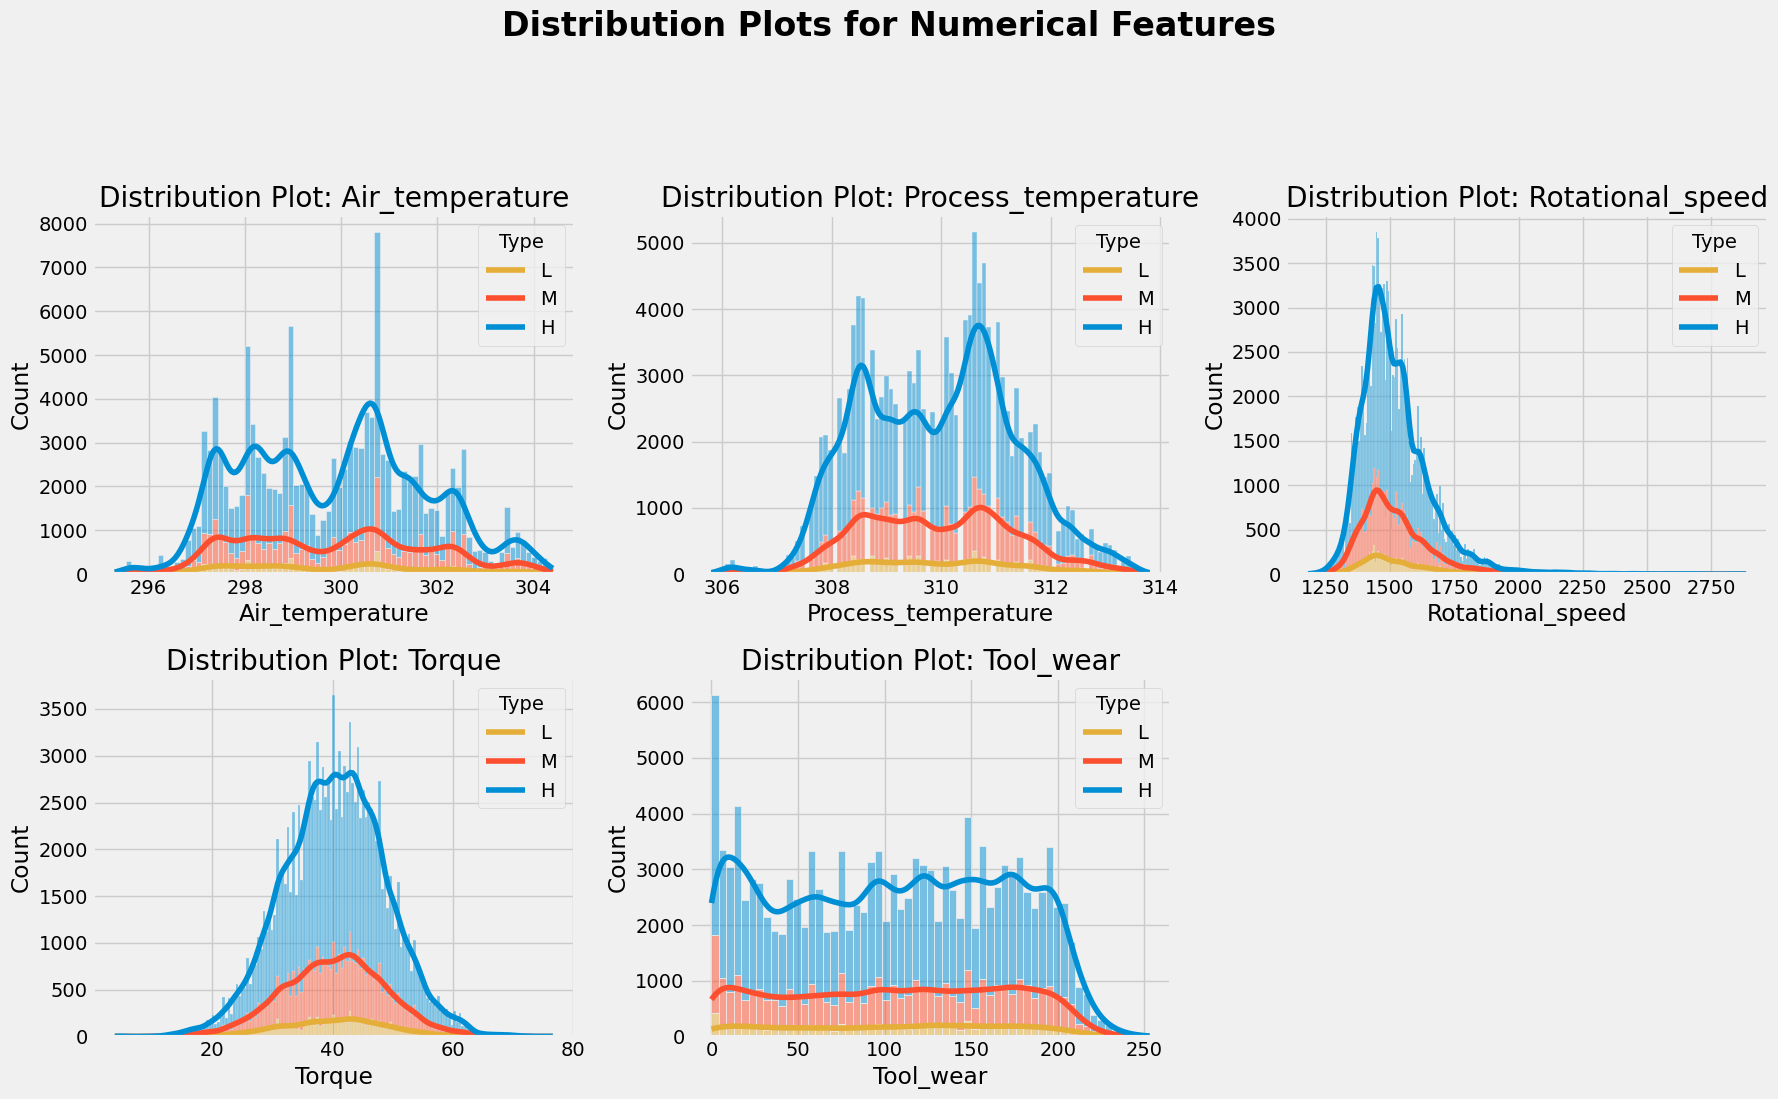

In [199]:

num_rows = 2
num_cols = 3
columns_to_plot = ['Air_temperature', 'Process_temperature', 'Rotational_speed', 
                             'Torque', 'Tool_wear']
eda.plot_numerical_distributions(train, columns_to_plot, num_rows, num_cols)

<div style="color:white;
           display:fill;
           border-radius:5px;
           background-color:#5642C5;
           font-size:110%;
           font-family:Verdana;
           letter-spacing:0.2px">

<p style="padding: 30px;
              color:white;">
REASONS FOR MACHINE FAILURE
</p>
</div>

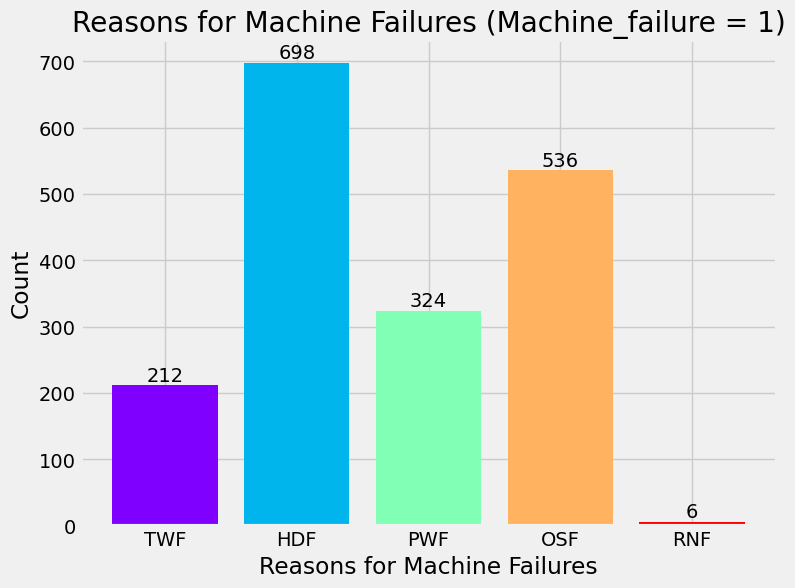

In [200]:
eda.plot_machine_reasons(train)



<div style="color:white;
           display:fill;
           border-radius:5px;
           background-color:#5642C5;
           font-size:110%;
           font-family:Verdana;
           letter-spacing:0.2px">

<p style="padding: 30px;
              color:white;">
OUTLIERS
</p>
</div>

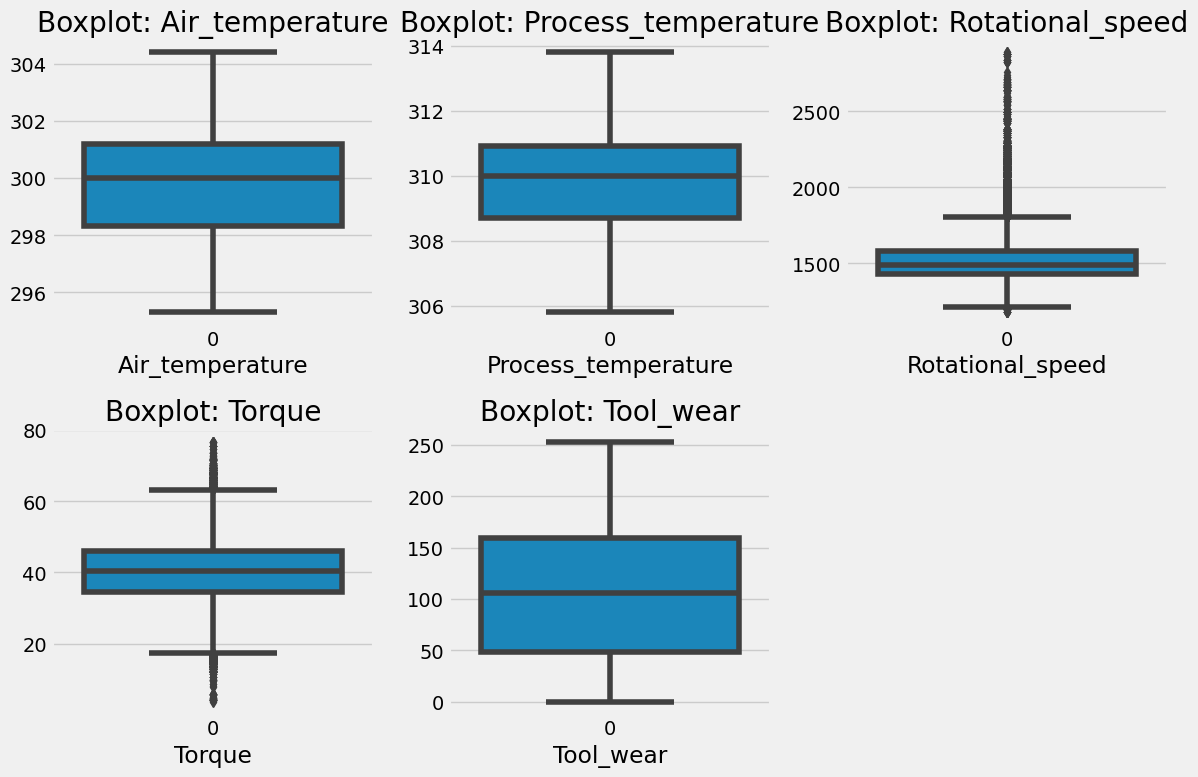

In [201]:
eda.plot_outliers(train,columns_to_plot)

<div style="color:white;
           display:fill;
           border-radius:5px;
           background-color:#5642C5;
           font-size:110%;
           font-family:Verdana;
           letter-spacing:0.2px">

<p style="padding: 30px;
              color:white;">
FEATURES EXTRACTION
</p>
</div>

In [202]:
train_updated = data.set_feature(train)
train_updated.drop(columns=['id','Product_ID'],axis=1,inplace=True)
train_updated.head()

,Type,Air_temperature,Process_temperature,Rotational_speed,Torque,Tool_wear,Machine_failure,TWF,HDF,PWF,OSF,RNF
0,1,300.6,309.6,1596,36.1,140,0,0,0,0,0,0
1,2,302.6,312.1,1759,29.1,200,0,0,0,0,0,0
2,1,299.3,308.5,1805,26.5,25,0,0,0,0,0,0
3,1,301.0,310.9,1524,44.3,197,0,0,0,0,0,0
4,2,298.0,309.0,1641,35.4,34,0,0,0,0,0,0


<div style="color:white;
           display:fill;
           border-radius:5px;
           background-color:#5642C5;
           font-size:110%;
           font-family:Verdana;
           letter-spacing:0.2px">

<p style="padding: 30px;
              color:white;">
DATASET SPLITS
</p>
</div>

In [203]:
y = data.set_label(train)
X_resampled,y_resampled = data.reduce_oversampling(train_updated,y)
X_train,X_val,y_train,y_val = data.random_split_data(X_resampled,y_resampled)
print(X_train.shape,X_val.shape,y_train.shape,y_val.shape)

(214849, 12) (53713, 12) (214849,) (53713,)


<div style="color:white;
           display:fill;
           border-radius:5px;
           background-color:#5642C5;
           font-size:110%;
           font-family:Verdana;
           letter-spacing:0.2px">

<p style="padding: 30px;
              color:white;">
DATA STANDARDIZATION
</p>
</div>

In [204]:
std_X_train = data.standardization_data(X_train)
std_X_val = data.standardization_data(X_val)
print(std_X_train[0],std_X_val[0])

[-0.27822181 -1.72018222 -1.32389097 -0.96206009  0.92759186  1.13736702
  0.99979057 -0.17967389 -0.45829591 -0.21741065  2.99836435 -0.03358039] [-0.27148309  0.01838727 -0.65203409  0.17594555  0.52073436 -1.61905775
 -0.99916256 -0.17846828 -0.45322008 -0.21394658 -0.33487232 -0.03507513]


<div style="color:white;
           display:fill;
           border-radius:5px;
           background-color:#5642C5;
           font-size:110%;
           font-family:Verdana;
           letter-spacing:0.2px">

<p style="padding: 30px;
              color:white;">
GENERIC TENSOR OPERATIONS
</p>
</div>

In [205]:
class Tensoroperations():
    
    def __init__(self):
        super(Tensoroperations,self).__init__()
    
    def convert_to_tensor(self,X,y=None):
        X_tensor = torch.tensor(X,dtype=torch.float32)
        y_tensor = torch.tensor(y,dtype=torch.float32)
        return X_tensor,y_tensor
        
    def convert_to_test_tesnor(self,X):
        X_tensor =  torch.tensor(X,dtype=torch.float32)
        return X_tensor
    
    def get_dataloaders(self,train_dataset,val_dataset):
        train_loaders = DataLoader(train_dataset,batch_size=256,shuffle=True)
        val_loaders = DataLoader(val_dataset,batch_size=32)
        return train_loaders,val_loaders
    
    def get_test_dataloaders(self,test_dataset,X_test):
        test_loaders = DataLoader(test_dataset,batch_size=X_test.shape[0])
        return test_loaders
        
        
    
tenops = Tensoroperations()    

<div style="color:white;
           display:fill;
           border-radius:5px;
           background-color:#5642C5;
           font-size:110%;
           font-family:Verdana;
           letter-spacing:0.2px">

<p style="padding: 30px;
              color:white;">
CUSTOM DATASETS
</p>
</div>

In [206]:
class CustomDataset(Dataset):
    
    def __init__(self,X_data,y_data=None,is_train=True):
        super().__init__()
        if is_train:
            self.X_data = X_data
            self.y_data = y_data
        else:
            self.X_data=X_train
            
    def __getitem__(self,index):
        return (self.X_data[index],self.y_data[index])
    
    def __len__(self):
        return len(self.X_data)



<div style="color:white;
           display:fill;
           border-radius:5px;
           background-color:#5642C5;
           font-size:110%;
           font-family:Verdana;
           letter-spacing:0.2px">

<p style="padding: 30px;
              color:white;">
TENSOR PREPARATION
</p>
</div>

In [207]:
X_tensor_train,y_tensor_train = tenops.convert_to_tensor(std_X_train,y_train.values)
X_tensor_val,y_tensor_val = tenops.convert_to_tensor(std_X_val,y_val.values)
print('The training tensor\n',X_tensor_train,y_tensor_train)
print('The validation tensor\n',X_tensor_val,y_tensor_val)

The training tensor
 tensor([[-0.2782, -1.7202, -1.3239,  ..., -0.2174,  2.9984, -0.0336],
        [-0.2782, -1.1299, -0.9797,  ..., -0.2174, -0.3335, -0.0336],
        [-0.2782, -0.5722,  0.5477,  ..., -0.2174, -0.3335, -0.0336],
        ...,
        [-2.6315,  0.2247,  1.0289,  ..., -0.2174, -0.3335, -0.0336],
        [-0.2782, -0.1066, -0.6035,  ...,  4.5996, -0.3335, -0.0336],
        [-2.6315, -0.0940, -0.2543,  ..., -0.2174, -0.3335, -0.0336]]) tensor([1., 1., 0.,  ..., 0., 1., 0.])
The validation tensor
 tensor([[-0.2715,  0.0184, -0.6520,  ..., -0.2139, -0.3349, -0.0351],
        [-0.2715,  0.3372,  1.1124,  ..., -0.2139, -0.3349, -0.0351],
        [-0.2715, -1.7884, -1.7748,  ..., -0.2139, -0.3349, -0.0351],
        ...,
        [-0.2715,  0.9761, -0.0888,  ..., -0.2139, -0.3349, -0.0351],
        [ 2.0801,  0.9218,  0.8718,  ..., -0.2139, -0.3349, -0.0351],
        [-0.2715, -0.0879,  0.0698,  ..., -0.2139, -0.3349, -0.0351]]) tensor([0., 0., 0.,  ..., 1., 0., 0.])


In [208]:
train_dataset = CustomDataset(X_tensor_train,y_tensor_train)
val_dataset = CustomDataset(X_tensor_val,y_tensor_val)

<div style="color:white;
           display:fill;
           border-radius:5px;
           background-color:#5642C5;
           font-size:110%;
           font-family:Verdana;
           letter-spacing:0.2px">

<p style="padding: 30px;
              color:white;">
DATA LOADERS
</p>
</div>

In [209]:
train_loaders,val_loaders=tenops.get_dataloaders(train_dataset,val_dataset)
print(next(iter(train_loaders)))

[tensor([[-0.2782, -0.7811, -0.1605,  ..., -0.2174, -0.3335, -0.0336],
        [-0.2782,  1.4988,  1.8443,  ..., -0.2174, -0.3335, -0.0336],
        [-0.2782,  0.5434,  0.2269,  ..., -0.2174, -0.3335, -0.0336],
        ...,
        [-0.2782, -0.9643, -0.9741,  ..., -0.2174,  2.9984, -0.0336],
        [ 2.0751, -0.0409, -0.5751,  ..., -0.2174, -0.3335, -0.0336],
        [ 2.0751,  0.4344,  0.1925,  ..., -0.2174, -0.3335, -0.0336]]), tensor([1., 1., 0., 1., 0., 0., 1., 0., 0., 0., 1., 1., 1., 1., 0., 0., 0., 0.,
        1., 0., 0., 1., 1., 1., 1., 0., 0., 0., 0., 1., 1., 1., 1., 0., 0., 1.,
        1., 0., 0., 1., 0., 0., 0., 0., 1., 0., 1., 0., 1., 1., 0., 1., 0., 1.,
        0., 0., 0., 0., 0., 0., 1., 1., 1., 0., 0., 1., 0., 1., 1., 1., 1., 1.,
        1., 0., 0., 0., 0., 1., 1., 0., 1., 0., 1., 1., 0., 0., 1., 1., 1., 0.,
        1., 0., 1., 1., 1., 1., 0., 1., 0., 1., 1., 1., 1., 0., 0., 0., 1., 1.,
        1., 0., 1., 0., 1., 0., 0., 1., 1., 0., 0., 0., 0., 1., 1., 0., 0., 1.,
    

<div style="color:white;
           display:fill;
           border-radius:5px;
           background-color:#5642C5;
           font-size:110%;
           font-family:Verdana;
           letter-spacing:0.2px">

<p style="padding: 30px;
              color:white;">
BINARY CLASSIFICATION DEEP MODEL
</p>
</div>

In [210]:
n_input_dim = X_train.shape[1]
#Layer size
n_hidden1 = 300  # Number of hidden nodes
n_hidden2 = 100
n_output =  1   # Number of output nodes = for binary classifier

class BinaryClassificationNN(torch.nn.Module):
    
    def __init__(self):
        super(BinaryClassificationNN, self).__init__()
        self.layer_1 = torch.nn.Linear(n_input_dim, n_hidden1) 
        self.layer_2 = torch.nn.Linear(n_hidden1, n_hidden2)
        self.layer_out = torch.nn.Linear(n_hidden2, n_output) 
        
        
        self.relu = torch.nn.ReLU()
        self.sigmoid =  torch.nn.Sigmoid()
        self.dropout = torch.nn.Dropout(p=0.1)
        self.batchnorm1 = torch.nn.BatchNorm1d(n_hidden1)
        self.batchnorm2 = torch.nn.BatchNorm1d(n_hidden2)
        
        
    def forward(self, inputs):
        x = self.relu(self.layer_1(inputs))
        x = self.batchnorm1(x)
        x = self.relu(self.layer_2(x))
        x = self.batchnorm2(x)
        x = self.dropout(x)
        x = self.sigmoid(self.layer_out(x))
        
        return x
    


binary_model = BinaryClassificationNN()
print(binary_model.state_dict())

OrderedDict([('layer_1.weight', tensor([[ 0.1031, -0.0559, -0.1260,  ..., -0.1392,  0.1306,  0.1832],
        [-0.2829, -0.0591, -0.2689,  ...,  0.2815,  0.1184,  0.1873],
        [ 0.2512,  0.1728, -0.1626,  ...,  0.0709,  0.2805,  0.2409],
        ...,
        [-0.1612, -0.1253, -0.1983,  ..., -0.2695,  0.2145, -0.1738],
        [ 0.2842,  0.1896, -0.2063,  ...,  0.0749, -0.0653, -0.1131],
        [ 0.0427, -0.0240,  0.2563,  ...,  0.0426, -0.1601,  0.0424]])), ('layer_1.bias', tensor([-0.0023,  0.0168, -0.1721, -0.0692,  0.0262, -0.2210,  0.1229,  0.2196,
         0.0213,  0.0906,  0.0866,  0.1758,  0.1642, -0.0954,  0.0271, -0.1056,
        -0.1280, -0.2835, -0.0717, -0.1054,  0.2745,  0.2449,  0.2440,  0.1410,
        -0.1337, -0.1203, -0.0751, -0.2867,  0.2755,  0.2223,  0.1624,  0.2848,
        -0.1415,  0.2334, -0.2283,  0.1632,  0.0864,  0.2536,  0.1751, -0.2503,
        -0.1832, -0.0498, -0.0848,  0.1915, -0.0639,  0.2180, -0.0244,  0.0736,
         0.0363, -0.1919, -0.0480, 

<div style="color:white;
           display:fill;
           border-radius:5px;
           background-color:#5642C5;
           font-size:110%;
           font-family:Verdana;
           letter-spacing:0.2px">

<p style="padding: 30px;
              color:white;">
TRAINING MODE
</p>
</div>

In [211]:
torch.manual_seed(42)
loss_fun = torch.nn.BCELoss()
optimizer = torch.optim.Adam(binary_model.parameters(), lr=1e-4)


gpy = GenericPytorch(binary_model,loss_fun,optimizer)
gpy.set_loaders(train_loaders,val_loaders)

In [212]:
print(gpy.model)

BinaryClassificationNN(
  (layer_1): Linear(in_features=12, out_features=300, bias=True)
  (layer_2): Linear(in_features=300, out_features=100, bias=True)
  (layer_out): Linear(in_features=100, out_features=1, bias=True)
  (relu): ReLU()
  (sigmoid): Sigmoid()
  (dropout): Dropout(p=0.1, inplace=False)
  (batchnorm1): BatchNorm1d(300, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm2): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)



<div style="color:white;
           display:fill;
           border-radius:5px;
           background-color:#5642C5;
           font-size:110%;
           font-family:Verdana;
           letter-spacing:0.2px">

<p style="padding: 30px;
              color:white;">
BINARY CLASSIFICATION MODEL TRAININIG
</p>
</div>

In [213]:
gpy.train(n_epochs=100)

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch=>[0]||Training Loss:=>0.07985||Validation Loss:=>0.05010
Epoch=>[10]||Training Loss:=>0.04912||Validation Loss:=>0.04911
Epoch=>[20]||Training Loss:=>0.04972||Validation Loss:=>0.04972
Epoch=>[30]||Training Loss:=>0.05022||Validation Loss:=>0.05022
Epoch=>[40]||Training Loss:=>0.05060||Validation Loss:=>0.05060
Epoch=>[50]||Training Loss:=>0.05072||Validation Loss:=>0.05072
Epoch=>[60]||Training Loss:=>0.05086||Validation Loss:=>0.05086
Epoch=>[70]||Training Loss:=>0.05102||Validation Loss:=>0.05102
Epoch=>[80]||Training Loss:=>0.05107||Validation Loss:=>0.05107
Epoch=>[90]||Training Loss:=>0.05139||Validation Loss:=>0.05139
Training Completed!!


<div style="color:white;
           display:fill;
           border-radius:5px;
           background-color:#5642C5;
           font-size:110%;
           font-family:Verdana;
           letter-spacing:0.2px">

<p style="padding: 30px;
              color:white;">
LOSS PLOT
</p>
</div>

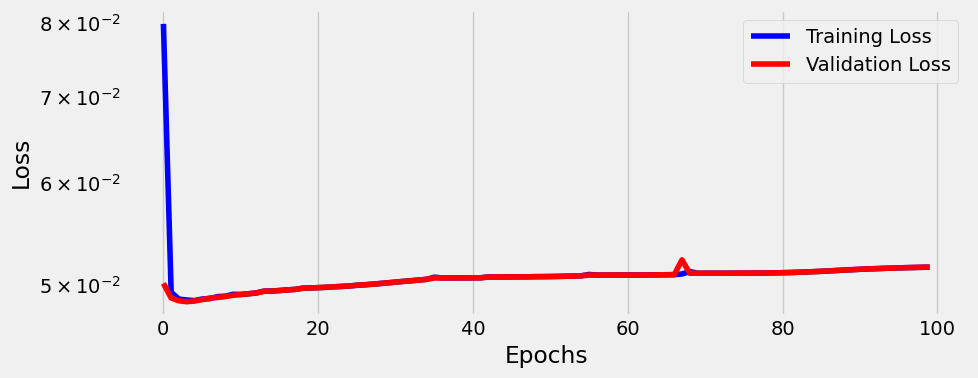

In [214]:
fig= gpy.plot_losses()

<div style="color:white;
           display:fill;
           border-radius:5px;
           background-color:#5642C5;
           font-size:110%;
           font-family:Verdana;
           letter-spacing:0.2px">

<p style="padding: 30px;
              color:white;">
ROC CURVE
</p>
</div>

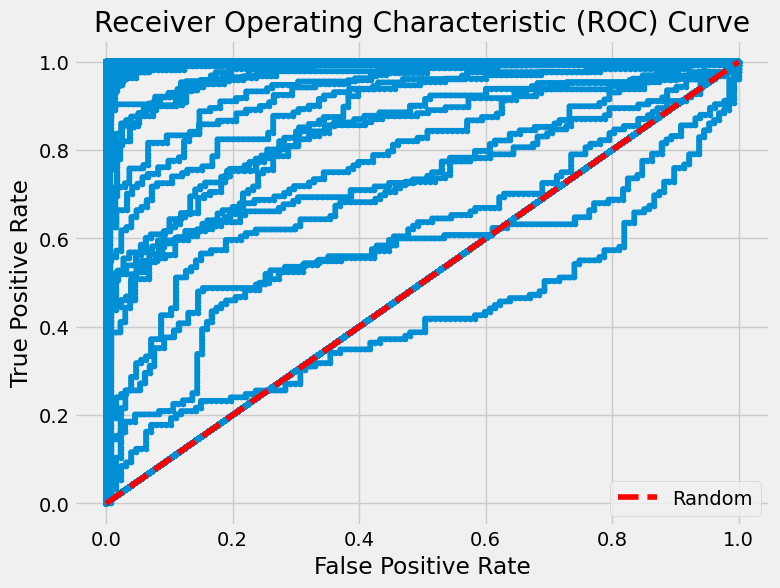

In [215]:
fpr = []
trp = []

for value in gpy.false_positive:
    for element in value:
        fpr.append(element)
        
for value in gpy.true_positive:
    for element in value:
        trp.append(element)
        
eda.plot_roc(fpr,trp)

<div style="color:white;
           display:fill;
           border-radius:5px;
           background-color:#5642C5;
           font-size:110%;
           font-family:Verdana;
           letter-spacing:0.2px">

<p style="padding: 30px;
              color:white;">
SAVING MODEL CHECKPOINT
</p>
</div>

In [216]:
gpy.save_checkpoint('model_checkpoint.pth')

<div style="color:white;
           display:fill;
           border-radius:5px;
           background-color:#5642C5;
           font-size:110%;
           font-family:Verdana;
           letter-spacing:0.2px">

<p style="padding: 30px;
              color:white;">
LOADING MODEL CHECKPOINT
</p>
</div>

In [217]:
gpy.load_checkpoint('model_checkpoint.pth')

<div style="color:white;
           display:fill;
           border-radius:5px;
           background-color:#5642C5;
           font-size:110%;
           font-family:Verdana;
           letter-spacing:0.2px">

<p style="padding: 30px;
              color:white;">
TEST DATA PREPARATION
</p>
</div>

In [218]:
test=data.get_dataframe('test.csv')
test = data.rename_column(test)
test.head()

,id,Product_ID,Type,Air_temperature,Process_temperature,Rotational_speed,Torque,Tool_wear,TWF,HDF,PWF,OSF,RNF
0,136429,L50896,L,302.3,311.5,1499,38.0,60,0,0,0,0,0
1,136430,L53866,L,301.7,311.0,1713,28.8,17,0,0,0,0,0
2,136431,L50498,L,301.3,310.4,1525,37.7,96,0,0,0,0,0
3,136432,M21232,M,300.1,309.6,1479,47.6,5,0,0,0,0,0
4,136433,M19751,M,303.4,312.3,1515,41.3,114,0,0,0,0,0


<div style="color:white;
           display:fill;
           border-radius:5px;
           background-color:#5642C5;
           font-size:110%;
           font-family:Verdana;
           letter-spacing:0.2px">

<p style="padding: 30px;
              color:white;">
TEST DATASET SUMMARY
</p>
</div>

In [219]:
data.summary('test',test)

,dtypes,null,unique,min,median,max,mean,std,duplicate
id,int64,0,90954,136429,181905.5,227382,181905.500000,26256.302529,0
Product_ID,object,0,9909,H29424,NaN,M24859,NaN,NaN,0
Type,object,0,3,H,NaN,M,NaN,NaN,0
Air_temperature,float64,0,92,295.3,300.0,304.4,299.859493,1.857562,0
Process_temperature,float64,0,84,305.7,310.0,313.8,309.939375,1.385296,0
Rotational_speed,int64,0,946,1168,1493.0,2886,1520.528179,139.970419,0
Torque,float64,0,595,3.8,40.5,76.6,40.335191,8.504683,0
Tool_wear,int64,0,246,0,106.0,253,104.293962,63.871092,0
TWF,int64,0,2,0,0.0,1,0.001473,0.038355,0
HDF,int64,0,2,0,0.0,1,0.005343,0.072903,0


In [220]:
test_updated = data.set_feature(test)
test_updated.drop(columns=['Product_ID'],axis=1,inplace=True)
test_updated

,id,Type,Air_temperature,Process_temperature,Rotational_speed,Torque,Tool_wear,TWF,HDF,PWF,OSF,RNF
0,136429,1,302.3,311.5,1499,38.0,60,0,0,0,0,0
1,136430,1,301.7,311.0,1713,28.8,17,0,0,0,0,0
2,136431,1,301.3,310.4,1525,37.7,96,0,0,0,0,0
3,136432,2,300.1,309.6,1479,47.6,5,0,0,0,0,0
4,136433,2,303.4,312.3,1515,41.3,114,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
90949,227378,1,302.3,311.4,1484,40.4,15,0,0,0,0,0
90950,227379,1,297.9,309.8,1542,33.8,31,0,0,0,0,0
90951,227380,1,295.6,306.2,1501,41.4,187,0,0,0,0,0
90952,227381,1,298.1,307.8,1534,40.3,69,0,0,0,0,0


In [221]:
data.summary('test',test_updated)

,dtypes,null,unique,min,median,max,mean,std,duplicate
id,int64,0,90954,136429.0,181905.5,227382.0,181905.500000,26256.302529,0
Type,int64,0,3,0.0,1.0,2.0,1.171010,0.522767,0
Air_temperature,float64,0,92,295.3,300.0,304.4,299.859493,1.857562,0
Process_temperature,float64,0,84,305.7,310.0,313.8,309.939375,1.385296,0
Rotational_speed,int64,0,946,1168.0,1493.0,2886.0,1520.528179,139.970419,0
Torque,float64,0,595,3.8,40.5,76.6,40.335191,8.504683,0
Tool_wear,int64,0,246,0.0,106.0,253.0,104.293962,63.871092,0
TWF,int64,0,2,0.0,0.0,1.0,0.001473,0.038355,0
HDF,int64,0,2,0.0,0.0,1.0,0.005343,0.072903,0
PWF,int64,0,2,0.0,0.0,1.0,0.002353,0.048449,0


<div style="color:white;
           display:fill;
           border-radius:5px;
           background-color:#5642C5;
           font-size:110%;
           font-family:Verdana;
           letter-spacing:0.2px">

<p style="padding: 30px;
              color:white;">
TEST DATA NORMALIZATION
</p>
</div>

In [222]:
std_X_test = data.standardization_data(test_updated)
print(std_X_test[0])

[-1.73203176 -0.32712561  1.31383019  1.12657041 -0.15380605 -0.27457863
 -0.69349379 -0.03841153 -0.07329437 -0.04856322 -0.06233076 -0.04810616]


<div style="color:white;
           display:fill;
           border-radius:5px;
           background-color:#5642C5;
           font-size:110%;
           font-family:Verdana;
           letter-spacing:0.2px">

<p style="padding: 30px;
              color:white;">
TEST TENSOR OPERATIONS
</p>
</div>

In [223]:
X_tensor_test = tenops.convert_to_test_tesnor(std_X_test)
print('The training tensor\n',X_tensor_train)


The training tensor
 tensor([[-0.2782, -1.7202, -1.3239,  ..., -0.2174,  2.9984, -0.0336],
        [-0.2782, -1.1299, -0.9797,  ..., -0.2174, -0.3335, -0.0336],
        [-0.2782, -0.5722,  0.5477,  ..., -0.2174, -0.3335, -0.0336],
        ...,
        [-2.6315,  0.2247,  1.0289,  ..., -0.2174, -0.3335, -0.0336],
        [-0.2782, -0.1066, -0.6035,  ...,  4.5996, -0.3335, -0.0336],
        [-2.6315, -0.0940, -0.2543,  ..., -0.2174, -0.3335, -0.0336]])


In [224]:
class CustomDatasetTest(Dataset):
    
    def __init__(self,X_data):
        super().__init__()
        self.X_data=X_data
            
    def __getitem__(self,index):
        return self.X_data[index]
    
    def __len__(self):
        return len(self.X_data)

<div style="color:white;
           display:fill;
           border-radius:5px;
           background-color:#5642C5;
           font-size:110%;
           font-family:Verdana;
           letter-spacing:0.2px">

<p style="padding: 30px;
              color:white;">
TEST DATASET AND DATA LOADER
</p>
</div>

In [225]:
test_dataset = CustomDatasetTest(X_tensor_train)
test_loaders=tenops.get_test_dataloaders(test_dataset,std_X_test)
print(next(iter(test_loaders)))

tensor([[-0.2782, -1.7202, -1.3239,  ..., -0.2174,  2.9984, -0.0336],
        [-0.2782, -1.1299, -0.9797,  ..., -0.2174, -0.3335, -0.0336],
        [-0.2782, -0.5722,  0.5477,  ..., -0.2174, -0.3335, -0.0336],
        ...,
        [-0.2782,  0.7236,  0.4291,  ..., -0.2174, -0.3335, -0.0336],
        [-0.2782,  1.2872,  0.6166,  ..., -0.2174, -0.3335, -0.0336],
        [-0.2782,  0.7028, -0.0137,  ..., -0.2174, -0.3335, -0.0336]])


In [230]:
"""
probability = gpy.predict(gpy.model,train_loaders) 
#Takes arrays and makes them list of list for each batch        
y_pred_list = [a.squeeze().tolist() for a in probability]
#flattens the lists in sequence
ytest_pred = list(itertools.chain.from_iterable(y_pred_list))
"""

AttributeError: 'list' object has no attribute 'to'

In [229]:
"""y_true_test = test.values.ravel()
conf_matrix = confusion_matrix(y_true_test ,ytest_pred)
print("Confusion Matrix of the Test Set")
print("-----------")
print(conf_matrix)
print("Precision of the MLP :\t"+str(precision_score(y_true_test,ytest_pred)))
print("Recall of the MLP    :\t"+str(recall_score(y_true_test,ytest_pred)))
print("F1 Score of the Model :\t"+str(f1_score(y_true_test,ytest_pred)))

"""


ValueError: Found input variables with inconsistent numbers of samples: [1091448, 214849]

<div style="color:white;
           display:fill;
           border-radius:5px;
           background-color:#5642C5;
           font-size:110%;
           font-family:Verdana;
           letter-spacing:0.2px">

<p style="padding: 40px;
              color:white;">
SUBMISSIONS
</p>
</div>

In [231]:
class Submit:
    
    def submit_predictions(self):
        probability = gpy.predict(gpy.model,test_loaders) 
        df_submit = pd.DataFrame(data={'id': test_updated['id'],'Machine Failure': probability[0]})
        df_submit.to_csv('submission.csv',index=False)
        print('Submission Completed!!')
        return df_submit
        
        
submit = Submit()
df_submit=submit.submit_predictions()

ValueError: Per-column arrays must each be 1-dimensional

<div style="color:white;
           display:fill;
           border-radius:5px;
           background-color:#5642C5;
           font-size:110%;
           font-family:Verdana;
           letter-spacing:0.2px">

<p style="padding: 30px;
              color:white;">
SUBMISSION VERIFICATIONS
</p>
</div>

In [ ]:
df_submit.head()